# An Analysis of the Top 5449 osu! Players - A Followup to My Midterm Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statistics

In my previous project, I analyzed the stats of the top 250 players in osu!, trying to determine what players should focus on to improve in the game. However, there were two issues. First, I did not have all the data I wanted to analyze, since the csv by Germán Heim only gave information about a player's accuracy, play count, and number of SS, S, and A rank plays. Since in this project, I'm webscraping on my own, I can scrape whatever data I want. The second issue is that 250 players proved to not be enough players. On top of being a small number already, many of the top players in osu! could be considered outliers with respect to the total osu! community, since the majority of players do not have the skill level, goals, and other attributes of the top 250.

This project aims to improve my previous project, analyzing a whole assortment of data from the top 5449 players, far more than my previous project.

# Webscraping

The webscraping for this project took, like, nine years. I ran into many, many issues, but finally, I have all the stats I need. Specifically, I got the username, global rank, country rank, performance points (pp), playtime, ranked score, hit accuracy, play count, total score, total hits, and maximum combo of the top 5449 players. Well, not exactly, because around 90 or so osu! players are missing. In addition, some players have the same rank. I'll get into both of those reasons as I go through the code I wrote.

```python
# loops through leaderboard pages
for i in range(1000):
    # gets leaderboard page data
    leaderboard_page = requests.get('https://osu.ppy.sh/rankings/osu/performance?page=' + str(i) + '#scores')
    leaderboard_soup = BeautifulSoup(leaderboard_page.content, 'html.parser')
    
    # finds all user links
    link_containers = leaderboard_soup.find_all(class_ = 'ranking-page-table__user-link-text js-usercard')
```

To start, I use the official osu! ranking leaderboard available on their website. Each of the leaderboard pages contains 50 players. However, the leaderboard pages do not contain all the stats I want, so I had to look at each individual player's page. This was done by retrieving the link of each player on a given leaderboard page, and then doing another webscrape on each link itself. The code above stores the 50 links (among other unused things) in link_containers.

```python
    # gets data of 10 users at a time, making sure to prevent getting rate limited
    with open('osu_data.csv', 'a') as osu_csv:
        time.sleep(10)
        csv_writer = csv.writer(osu_csv, delimiter = ',', lineterminator = '\n')
        ThreadPool(10).map(get_data, link_containers[0:10])
        time.sleep(10)
        ThreadPool(10).map(get_data, link_containers[10:20])
        time.sleep(10)
        ThreadPool(10).map(get_data, link_containers[20:30])
        time.sleep(10)
        ThreadPool(10).map(get_data, link_containers[30:40])
        time.sleep(10)
        ThreadPool(10).map(get_data, link_containers[40:50])
        time.sleep(10)
```

This code then takes each of those 10 user page links at a time, and runs the `get_data` function on each one. It runs 10 different threads of `get_data` at a time, and then waits 10 seconds before doing another 10. The reason it uses multithreading is because otherwise it would take forever (for reasons that will be explained later), and the reason it only uses 10 threads at a time and has a 10 second break in between each one is to prevent getting rate limited, that is, the osu! website will only allow a certain number of requests to their website before it blocks a user from using it. 

I actually accidently got rate limited when I first started writing this code. The osu!API website states that there is a rate limit of an absurd 1200 requests per minute, plus another 200 request burst padding, but I didn't want to use the API, as that wouldn't be actual webscraping. So, I didn't, but it turns out that the rate limit is far lower if you aren't using the API and instead are requesting webpages directly. However, to get around the rate limit, I used a VPN to switch my ip and then proceeded to be a lot more careful.

Anyways, so each of these user links gets passed into `get_data`. Now what?

```python
# webdriver options
options = Options()
options.add_argument('--headless') # runs chrome instance without gui
options.add_argument('--disable-gpu') # runs chrome instance without gpu

# gets data from a player page
def get_data(url_container):
    user_data = []
    
    # creates chrome instance
    driver = webdriver.Chrome(ChromeDriverManager().install(), options = options)
    driver.implicitly_wait(1000)
    
    # gets page contents
    driver.get(url_container['href'])
    player_page = driver.page_source
    
    driver.quit()
    
    player_soup = BeautifulSoup(player_page, 'html.parser')
```

So, it turns out that user pages work differently than the leaderboard pages. They use React, a framework which retrieves data to display on the webpage in real time *after* a web page loads. Uh oh. Turns out, you can't use normal requests to get the data from here. So, we have to use webdrivers to *simulate* loading a page. Webdrivers are normally used to test websites quickly with different browsers, but they're also useful for webscraping in scenarios like these.

However, webdrivers come with a caveat. Webdriver instances all run off of a standalone program, usually an exe file. However, Jupyterhub doesn't give me permission to run exe files on whatever server these files are hosted on, likely due to ASU staff preventing it (for good reason). I tried to fix it by using a package called webdriver_manager, but all it does is download the webdriver automatically, still needing the webdriver to be run. As a result, I had to switch to Spyder instead, which is why this code isn't actually run here.

One last thing is that the webdriver itself runs with two options. First, `--headless`, which prevents an actual window opening, instead just running the browser instance in the background, and `--disable-gpu`, which is self explanatory.

So finally, with this step, we have some soup with all the data we actually want.

```python
    if player_soup.find("h1", {"class":"profile-info__name"}) is not None:
```

Or so we thought. It turns out, for whatever reason, sometimes the username just doesn't load in. I have no idea how to fix this a properly, but what I *should* have done is put the entire first section of `get_data` in a while loop, restarting it if the username shows up as null. However, I realized far too late, and wasn't willing to restart the entire scraping process. As a result, as I mentioned earlier, 90 or so users are missing from the dataset.

```python
        user_data.append(next(player_soup.find("h1", {"class":"profile-info__name"}).children).text) # username
        
        ranks_and_pp = player_soup.find_all("div", {"class":"value-display__value"})
        user_data.append(next(ranks_and_pp[0].children).text.replace(',', '').replace('#', '')) # global rank
        user_data.append(next(ranks_and_pp[1].children).text.replace(',', '').replace('#', '')) # country rank
        user_data.append(next(ranks_and_pp[4].children).text.replace(',', '')) # pp
        
        # playtime
        playtime_unformatted = player_soup.find("span", {"data-tooltip-position":"bottom center"}).text
        playtime_list = playtime_unformatted.split(' ')
        days_in_minutes = int(playtime_list[0].replace('d', '')) * 1440
        hours_in_minutes = int(playtime_list[1].replace('h', '')) * 60
        minutes = int(playtime_list[2].replace('m', ''))
        user_data.append(str(days_in_minutes + hours_in_minutes + minutes))
        
        stats = player_soup.find_all("dd", {"class":"profile-stats__value"})
        user_data.append(stats[0].text.replace(',', '')) # ranked score
        user_data.append(stats[1].text.replace('%', '')) # hit accuracy
        user_data.append(stats[2].text.replace(',', '')) # play count
        user_data.append(stats[3].text.replace(',', '')) # total score
        user_data.append(stats[4].text.replace(',', '')) # total hits
        user_data.append(stats[5].text.replace(',', '')) # maximum combo
        csv_writer.writerow(user_data)
```

Finally, this last code segment simply retrieves all the data we need and formats it as necessary before writing it to a csv. Except I ran into one more issue. For some reason, a couple of times I got the error "No connection could be made because the target machine actively refused it." (It's more complicated than that but that's the important bit). This is not just me getting rate limited, as I could access the webpage after I recieved it. However, I was able to work around it. Since each page holds 50 usernames, I could just delete lines in the csv in the current batch of 50 that got interrupted, then shift the index in the very first loop so the code resumes scraping from whatever leaderboard page it needs to. I only had to do it 3 or 4 times anyways.

Two final caveats. First, some of the users are the same rank. There are two reasons for this. First of all, the rank of players that gets displayed isn't always updated when it's retrieved, getting updated only every once in a while or when a player submits a new play. As a result, if one player passes another player by setting a good play, the player that got passed will not immediately have their rank changed. Second of all, the data was being retrieved over several hours, so it's possibly that someone's rank changed during the retrieval process, causing minor inconsistencies. Still, none of this really matters, since the data is still very accurate.

The second caveat is that I got a couple duplicate rows. I have no idea why this happened, but it's easily resolvable after I load the data into a dataframe. Onward!

# Dataframe
Very, very simple to make since I had the csv created already. It first reads the csv, setting column names as necessary. Then, it drops the duplicate rows, sorts by global rank, and resets the index afterwards. That's it!

In [2]:
# creates dataframe from csv
osu_df = pd.read_csv('osu_data.csv', names = ['username', 'global_rank', 'country_rank', 'pp', 'playtime', 'ranked_score', 'hit_accuracy', 'play_count', 'total_score', 'total_hits', 'maximum_combo'])

# drops duplicate rows, sorts values by rank, and resets the index
osu_df = osu_df.drop_duplicates().sort_values('global_rank').reset_index(drop = True)

osu_df

,username,global_rank,country_rank,pp,playtime,ranked_score,hit_accuracy,play_count,total_score,total_hits,maximum_combo
0,rushia1,1,1,21667,79384,3.576356e+10,98.29,107531,2.160000e+11,22951826,6638
1,WhiteCat,2,1,19573,29598,2.069666e+10,98.62,29409,1.360000e+11,9806897,6229
2,RyuK,3,1,18646,168235,8.815587e+10,98.79,224051,6.210000e+11,46400115,7282
3,aetrna,4,2,18606,119040,1.964327e+10,97.50,150326,1.960000e+11,33577003,3850
4,Vaxei,5,1,18012,128727,5.672025e+10,98.99,158163,4.590000e+11,35557292,7540
...,...,...,...,...,...,...,...,...,...,...,...
5358,Yuzuki Roa,5445,273,8247,78806,2.551048e+10,98.61,98807,1.803231e+11,19735828,5972
5359,Hallo,5445,43,8247,61713,3.507005e+09,93.57,85999,3.303609e+10,15547683,1059
5360,jpjtyld,5447,190,8247,50777,1.435512e+10,97.88,48916,8.554080e+10,14566921,3992
5361,hungrytiger,5448,274,8247,44743,1.516047e+10,99.14,51081,9.568961e+10,10626585,2010


Hey look! We can even find me in the dataset! I can simply look up my username and see all of my stats!

In [3]:
osu_df.loc[osu_df['username'] == 'Phx_Blaster007']

,username,global_rank,country_rank,pp,playtime,ranked_score,hit_accuracy,play_count,total_score,total_hits,maximum_combo
968,Phx_Blaster007,980,191,10803,63003,1.489313e+10,96.59,84589,8.223516e+10,15797351,3891


# Does Playing More Affect Your Rank - Revisited
Finally, the big reveal. The primary reason I scraped such a big dataset was to see a much stronger correlation between rank and play time. So, lets graph it.

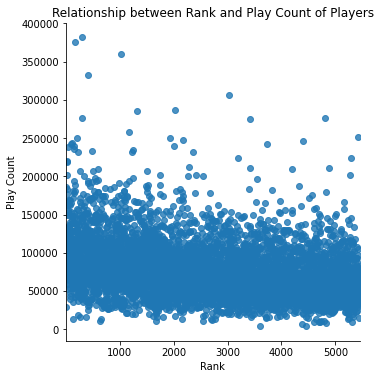

In [4]:
# plot
sns.lmplot(data = osu_df, x = 'global_rank', y = 'playtime')

# color
sns.set_palette("Paired")

# labels
plt.title("Relationship between Rank and Play Count of Players")
plt.xlabel('Rank')
plt.ylabel('Play Count')

plt.show()

Wow! It's even worse than before! You can see the slight trend as rank gets very high (towards the left), but on the right it's completely flat relationship! The worst possible scenario!

So, what's actually going on here? It turns out that, even though we have approximately 5500 players to look at, it pales in comparison to the millions of players that play the game. In fact, the game has a total of 15 million users. So, these players are in the top 0.037% of all players! As a result, these players can *still* be considered the extreme case, where they are so good that playtime doesn't necessarily reflect their rank.

On another note, as for why this graph isn't colored more interestingly... I wanted to color it buy players' play count, so I could see the relationship between play time and play count. But, it turns out sns really does not like rendering extremely large amounts of points. Check out what happens below!

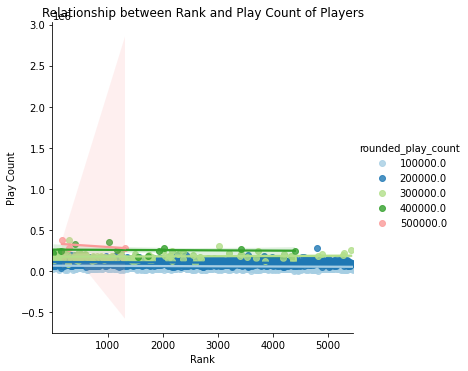

In [5]:
# creates a column of rounded play_count values to be used as colors
osu_df['rounded_play_count'] = (osu_df['play_count'] / 100000).apply(np.ceil) * 100000

# plot
sns.lmplot(data = osu_df, x = 'global_rank', y = 'playtime', hue = 'rounded_play_count')

# drops rounded play count column
osu_df.drop('rounded_play_count', axis = 1)

# labels
plt.title("Relationship between Rank and Play Count of Players")
plt.xlabel('Rank')
plt.ylabel('Play Count')

plt.show()

There's an attribute called "estimator" that would've been perfect to fix this. But it's currently non-functional. Unfortunate, but there's nothing I can do.

# Is the Correlation between Playtime and Play Count So Clear?
This seems like something totally unnecessary to view. But it's not. The reason is because there are actually different ways osu! players choose the songs they play. The primary reason for this is because of the pp system. While longer maps are often more enjoyable to play, the best way to gain pp in osu! is to actually play short maps. This means that some players may prioritize playing longer maps, resulting in a longer playtime relative to their play count, while other players may prioritize playing shorter maps, resulting in a shorter playtime relative to their play count. In addition, pp is mainly only rewarded for full comboing a map, which is when a player hits every note. Thus, if a player misses a note, they may retry immediately. This still results in the play count increasing, but the playtime for that play would be very, very short, even shorter than the song length. So, I'm looking to see if any of this is reflected in the graph.

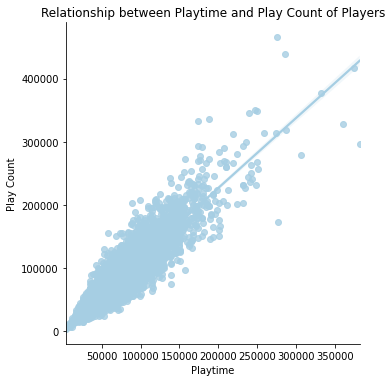

In [6]:
# plot
sns.lmplot(data = osu_df, x = 'playtime', y = 'play_count')

# color
sns.set_palette("Paired")

# labels
plt.title("Relationship between Playtime and Play Count of Players")
plt.xlabel('Playtime')
plt.ylabel('Play Count')

plt.show()

Yes, there is indeed quite a bit of variability between the proportions of players' play count and playtime. This indicates players' preference of shorter or longer maps. I would have loved to see this colorized by rank, so that we could see if higher rank players (which necessarily have more pp) would have been below the line, which I would predict. But once again, I can't without it breaking.

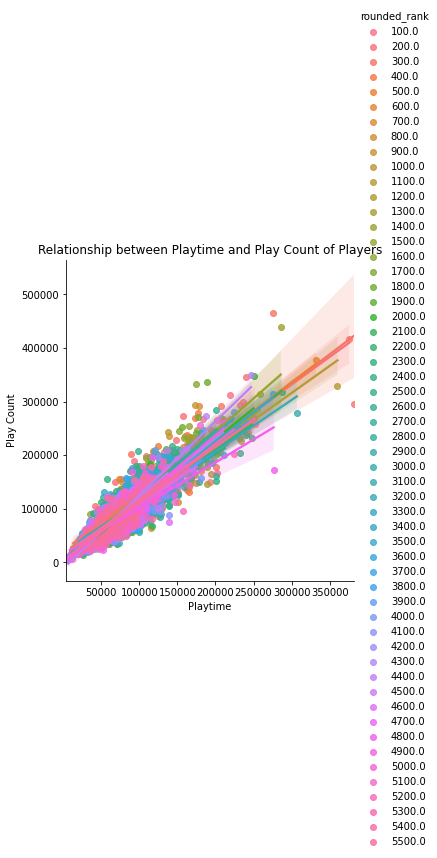

In [7]:
# creates a column of rounded rank values to be used as colors
osu_df['rounded_rank'] = (osu_df['global_rank'] / 100).apply(np.ceil) * 100

# plot
sns.lmplot(data = osu_df, x = 'playtime', y = 'play_count', hue = 'rounded_rank')

# drops rounded rank column
osu_df.drop('rounded_rank', axis = 1)

# labels
plt.title("Relationship between Playtime and Play Count of Players")
plt.xlabel('Playtime')
plt.ylabel('Play Count')

plt.show()

Again, we see the same issue.

Anyways, let's look a little bit deeper into the linear regression of this data, along with a little univariate analysis.

In [8]:
# gets values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(osu_df['playtime'], osu_df['play_count'])

# prints values
print('p_value =', p_value)
print('r_value =', r_value)
print('average playtimer per play =', 
      (statistics.mean(osu_df['playtime']) / statistics.mean(osu_df['play_count'])) * 60, 
      'seconds')

p_value = 0.0
r_value = 0.894046569843346
average playtimer per play = 50.83063883595475 seconds


First, the p-value. It's not that the p-value is 0. It's that the chance of there not being a linear relationship between playtime and play count is so low, linregress isn't precise enough to give the true p-value, that is, the p-value is *incredibly* small. It makes sense though, as the scatterplot clearly demonstrates a linear relationship. 

Next, the r-value of 0.89 indicates there is quite a bit of variation. This is just a quantification of the qualitative analysis made earlier about the variability earlier, but it's nice to see nonetheless. 

The slope here isn't particularly useful. That's because while the slope may be useful for determining the average playtime per play, there is a much better way to find that, which is by dividing the average playtime by the average play count. Our result is around 50.83 seconds, which is honestly far shorter than I expected. Maps definitely are not 50.83 seconds long on average, so it means that people are either playing lots of short maps to get pp or are retry spamming a lot.

# Does PP Scale Differently Depending on Rank Range?
In general, pp seems to follow a generally consistent trend, with players with similar ranks having very similar pp values. However, the best of the best seem to have more disparity in their pp values. That is, I believe the rank 1000 player would have a *significantly* closer pp value to the rank 2000 osu player than to the rank 1 osu player. So, simply plotting rank against pp would be able to determine whether this is the case.

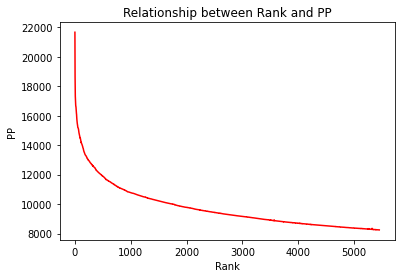

In [9]:
plt.plot(osu_df['global_rank'], osu_df['pp'], c = 'red')
plt.title("Relationship between Rank and PP")
plt.xlabel('Rank')
plt.ylabel('PP')
plt.show()

Wow! This completely confirms my hypothesis! It seems that osu! players at the very top level have pp that scales significantly faster than players somewhat close. There isn't too much else to say about this, other than that, being rank 980, I'm a lot farther from the best than people typically think.

# Showcase of Accuracy V2
In my midterm project, I found the proportion of players by accuracy, and showed it in a pie chart. For the top 250 players, over half of the players at 98% accuracy (rounded down), and the rest of the players were primarily split between average 99% and 97% accuracy, with very few players having 96% accuracy or lower. However, I believe that there will be more players with lower accuracy when we include lower ranked players. The larger dataset should provide some interesting results.

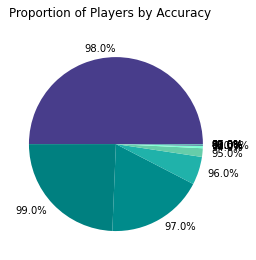

In [10]:
colors = ["darkslateblue", "teal", "darkcyan", "lightseagreen", "mediumaquamarine", "aquamarine"]
rounded_acc = osu_df['hit_accuracy'].apply(np.floor).value_counts()
plt.pie(rounded_acc.values, labels = rounded_acc.index.astype(str) + '%', colors = colors)
plt.suptitle("Proportion of Players by Accuracy")
plt.show()

There is indeed a difference between both pie charts! However, the differences are not quite as expected. First of all, the amount of players with 98% accuracy is almost exactly half, while in the top 250, players with 98% made up more than half of the chart. However, most surprisingly, the amount of players with 99% accuracy is actually higher here than in the top 250. I believe the explanation comes from the fact that osu! maps which reward high pp are often extremely difficult to get high accuracy on, and since the higher rank a player is, the more pp they have, higher rank players have slightly lower accuracy. That being said, if a player's accuracy is too low, they don't get rewarded much pp either, which would explain why the top 250 don't have *extremely* low accuracy.

# Follow Up
Ideas for follow up analysis:
- Analyze relationship between players' max combo and total score (since higher combo results in *exponentially* higher score on any given map)
- Use an *even bigger* dataset for analyzing the relationship between playtime and rank
- Attempt to determine whether a player primarily plays to try to get pp (pp farms) or not by taking several variables into account, including the proportion of their play count to their playtime, and possibly even the total amount of pp relative to play count as well.